# NDVI Calculation and Shapefile Processing from Drone Imagery
-----------
**Author: Mohammadreza Narimani, Digital Agriculture Laboratory, UC Davis**

This Jupyter Notebook demonstrates how to calculate the Normalized Difference Vegetation Index (NDVI) using drone imagery data. The process involves the following steps:

1. **Read and display the Red band** of the imagery.
2. **Read and display the Near-Infrared (NIR) band** of the imagery.
3. **Calculate and display the NDVI** using the Red and NIR bands.
4. **Read shapefiles** (e.g., field boundaries or specific regions of interest).
5. **Edit the shapefiles** as needed.
6. **Clip the NDVI** based on the regions defined in the shapefiles and extract the NDVI values for each region.

---------
## Import Required Libraries

This cell imports the necessary libraries for reading, processing, and visualizing drone imagery data, as well as working with shapefiles. The key libraries include `rasterio` for raster data, `numpy` for numerical operations, `matplotlib` and `seaborn` for visualization, and `geopandas` for shapefile manipulation.


In [1]:
# Importing the required libraries

import rasterio  # For reading and working with raster data
import numpy as np  # For numerical operations, including NDVI calculation
import matplotlib.pyplot as plt  # For displaying images
import seaborn as sns  # For enhanced visualization (optional)
import geopandas as gpd  # For working with shapefiles
import pandas as pd #For CSV file edit
import rasterio.features #For feature extraction
from rasterio.plot import show  # For displaying raster data easily
from shapely.geometry import box  # For creating bounding box for clipping
from shapely.ops import unary_union #For shapefile adjustment
from shapely.geometry import Polygon #For adjustment of polygons
from rasterio.mask import mask  # For masking and cropping rasters with shapefiles
from mpl_toolkits.axes_grid1 import make_axes_locatable #For adjusting colorbar size

----------
## Read and Display the Red Band

In this step, we will read the Red band from the drone imagery using the `rasterio` library and display it. The Red band is crucial for calculating vegetation indices such as NDVI, which will be used later.


Minimum pixel value after clipping: 0.0
Maximum pixel value after clipping: 0.05971386656165123


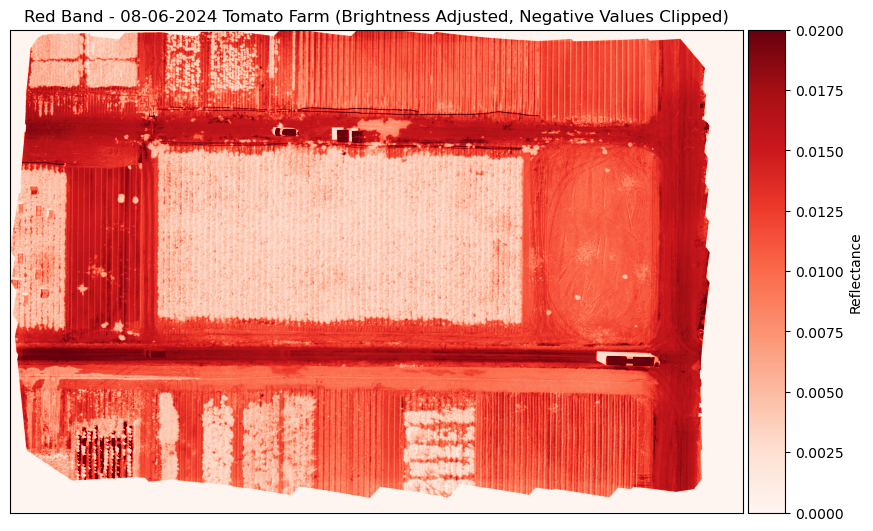

In [2]:
# File path to the Red band raster
red_band_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\Data\08-06-2024_DrKisekka-Tomato_Farm_transparent_reflectance_red.tif"

# Open the Red band using rasterio
with rasterio.open(red_band_path) as red_band:
    red_band_data = red_band.read(1)  # Read the first (and only) band
    red_band_meta = red_band.meta  # Metadata of the red band

# Replace negative values with 0
red_band_data = np.clip(red_band_data, 0, None)

# Check the actual pixel value range after clipping
min_value = np.min(red_band_data)
max_value = np.max(red_band_data)

# Print out the new range of values
print(f"Minimum pixel value after clipping: {min_value}")
print(f"Maximum pixel value after clipping: {max_value}")

# Set the minimum and maximum values for display (adjust brightness based on actual pixel range)
vmin, vmax = min_value, min_value + 0.02  # Small range based on min value

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
plt.title("Red Band - 08-06-2024 Tomato Farm (Brightness Adjusted, Negative Values Clipped)")
img = ax.imshow(red_band_data, cmap='Reds', vmin=vmin, vmax=vmax)

# Turn off axis numbers
ax.set_xticks([])
ax.set_yticks([])

# Make the color bar shorter using make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and pad for the colorbar
cbar = fig.colorbar(img, cax=cax)
cbar.set_label("Reflectance")

plt.show()

------------------
## Read and Display the NIR Band

In this step, we will read the Near-Infrared (NIR) band from the drone imagery and display it with a brightness adjustment. The NIR band is crucial for calculating the NDVI in combination with the Red band. The color map used for this visualization will be purple.


Minimum pixel value after clipping: 0.0
Maximum pixel value after clipping: 0.12740455567836761


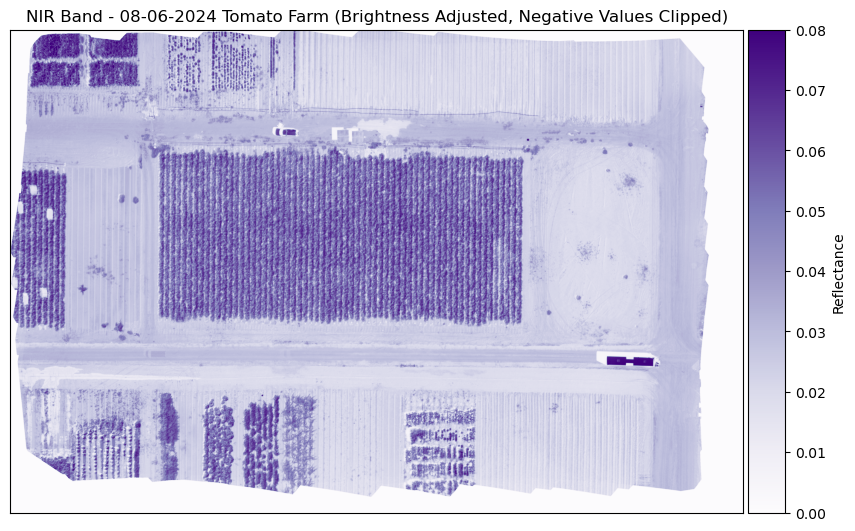

In [3]:
# File path to the NIR band raster
nir_band_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\Data\08-06-2024_DrKisekka-Tomato_Farm_transparent_reflectance_nir.tif"

# Open the NIR band using rasterio
with rasterio.open(nir_band_path) as nir_band:
    nir_band_data = nir_band.read(1)  # Read the first (and only) band
    nir_band_meta = nir_band.meta  # Metadata of the NIR band

# Replace negative values with 0
nir_band_data = np.clip(nir_band_data, 0, None)

# Check the actual pixel value range after clipping
min_value = np.min(nir_band_data)
max_value = np.max(nir_band_data)

# Print out the new range of values
print(f"Minimum pixel value after clipping: {min_value}")
print(f"Maximum pixel value after clipping: {max_value}")

# Set the minimum and maximum values for display (adjust brightness based on actual pixel range)
vmin, vmax = min_value, min_value + 0.08  # Small range based on min value

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
plt.title("NIR Band - 08-06-2024 Tomato Farm (Brightness Adjusted, Negative Values Clipped)")
img = ax.imshow(nir_band_data, cmap='Purples', vmin=vmin, vmax=vmax)  # Using 'Purples' for NIR band

# Turn off axis numbers
ax.set_xticks([])
ax.set_yticks([])

# Make the color bar shorter using make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and pad for the colorbar
cbar = fig.colorbar(img, cax=cax)
cbar.set_label("Reflectance")

plt.show()

--------
## NDVI Calculation and Display

The Normalized Difference Vegetation Index (NDVI) is a common indicator used in remote sensing to assess vegetation health. It is calculated using the Near-Infrared (NIR) and Red bands from drone imagery using the following formula:

$$\text{NDVI} = \frac{\text{NIR} - \text{RED}}{\text{NIR} + \text{RED}}$$

The NDVI values typically range from -1 to 1, where higher values indicate healthier vegetation. In this step, we calculate and display the NDVI using the Red and NIR bands, with the color map `RdYlGn` to represent vegetation health.


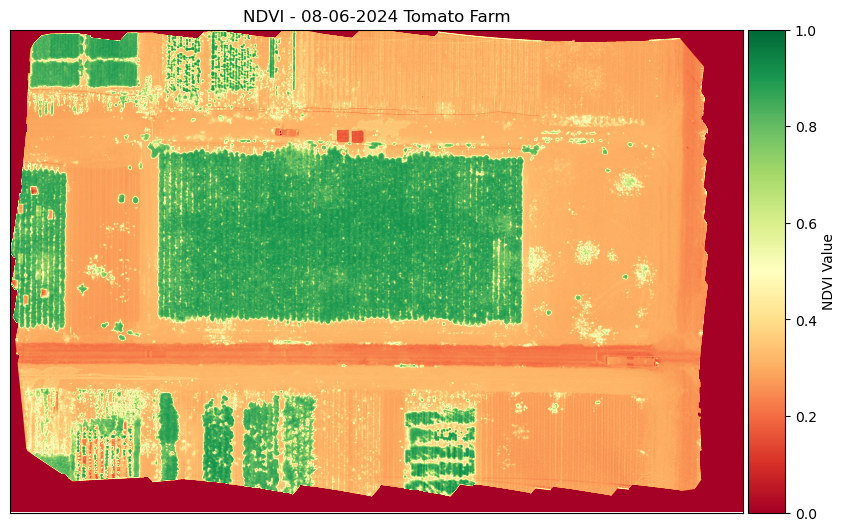

In [4]:
# File paths to the Red and NIR band rasters
red_band_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\Data\08-06-2024_DrKisekka-Tomato_Farm_transparent_reflectance_red.tif"
nir_band_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\Data\08-06-2024_DrKisekka-Tomato_Farm_transparent_reflectance_nir.tif"

# Open and read the Red band
with rasterio.open(red_band_path) as red_band:
    red_band_data = red_band.read(1)
    red_band_data = np.clip(red_band_data, 0, None)  # Replace negative values with 0

# Open and read the NIR band
with rasterio.open(nir_band_path) as nir_band:
    nir_band_data = nir_band.read(1)
    nir_band_data = np.clip(nir_band_data, 0, None)  # Replace negative values with 0

# Calculate NDVI
ndvi = (nir_band_data - red_band_data) / (nir_band_data + red_band_data + 1e-10)  # Small epsilon added to avoid division by zero

# Set the range for NDVI values to -1 to 1
ndvi = np.clip(ndvi, -1, 1)

# Display NDVI using matplotlib
fig, ax = plt.subplots(figsize=(10, 8))
plt.title("NDVI - 08-06-2024 Tomato Farm")
img = ax.imshow(ndvi, cmap='RdYlGn', vmin=0, vmax=1)  # Using RdYlGn color map for NDVI

# Turn off axis numbers
ax.set_xticks([])
ax.set_yticks([])

# Make the color bar shorter using make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and pad for the colorbar
cbar = fig.colorbar(img, cax=cax)
cbar.set_label("NDVI Value")

plt.show()

-------------
## Read and Display Shapefile Metadata

In this step, we will read a shapefile containing polygon data (e.g., field boundaries or regions of interest) using the `geopandas` library. Once the shapefile is read, we will display its metadata, including the coordinate reference system (CRS) and other relevant details.

In [5]:
# File path to the shapefile
shapefile_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\SHP\DrKisekka_Tomato\Procedures\Shapefile\polygons_shapefile\polygons_shapefile.shp"

# Read the shapefile using geopandas
shapefile = gpd.read_file(shapefile_path)

# Print the metadata of the shapefile
print("Shapefile Metadata:")
print(f"Coordinate Reference System (CRS): {shapefile.crs}")
print(f"Number of features (geometries): {len(shapefile)}")
print(f"Columns (Attributes): {list(shapefile.columns)}")

# Display the first few rows of the shapefile's attribute table
print("\nShapefile Attribute Table (First 5 rows):")
print(shapefile.head())

Shapefile Metadata:
Coordinate Reference System (CRS): EPSG:32610
Number of features (geometries): 126
Columns (Attributes): ['T_ID', 'T_row', 'T_col', 'geometry']

Shapefile Attribute Table (First 5 rows):
   T_ID  T_row  T_col                                           geometry
0     1      1      1  POLYGON ((606242.702 4265896.773, 606244.167 4...
1     2      1      2  POLYGON ((606242.599 4265874.444, 606244.064 4...
2     3      2      1  POLYGON ((606244.166 4265896.751, 606245.631 4...
3     4      2      2  POLYGON ((606244.064 4265874.422, 606245.528 4...
4     5      3      1  POLYGON ((606245.631 4265896.730, 606247.096 4...


-----------------
## Merge Polygons by T_row and Save the Updated Shapefile

In this step, we group the polygons based on the `T_row` attribute and merge the polygons for each `T_row`, specifically combining the polygons for `T_col` 1 and `T_col` 2 into a single rectangular polygon. The merged shapefile is then saved in the specified directory.


In [6]:
# File path to the original shapefile
shapefile_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\SHP\DrKisekka_Tomato\Procedures\Shapefile\polygons_shapefile\polygons_shapefile.shp"

# Read the shapefile using geopandas
shapefile = gpd.read_file(shapefile_path)

# Apply a small buffer to close any tiny gaps between polygons
shapefile['geometry'] = shapefile['geometry'].buffer(0.01)

# Group the polygons by 'T_row' and merge the geometries for each group
def merge_and_simplify(group):
    merged = unary_union(group)
    if merged.geom_type == 'MultiPolygon':
        # Simplify MultiPolygon by taking the convex hull or bounding box to merge them properly
        merged = Polygon(merged.convex_hull)
    return merged

merged_polygons = shapefile.groupby('T_row').agg({
    'geometry': lambda g: merge_and_simplify(g)  # Merge and simplify geometries for each T_row
}).reset_index()

# Merge the new geometry back into the original data, and make sure it's a GeoDataFrame
merged_shapefile = shapefile.drop(columns='geometry').drop_duplicates(subset='T_row').merge(merged_polygons, on='T_row')

# Convert the merged result back to a GeoDataFrame
merged_shapefile = gpd.GeoDataFrame(merged_shapefile, geometry='geometry', crs=shapefile.crs)

# Output path for the updated shapefile
output_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\SHP\DrKisekka_Tomato\Procedures\Shapefile\polygons_shapefile_Updated\polygons_shapefile_Updated.shp"

# Save the updated shapefile to the specified directory
merged_shapefile.to_file(output_path)

# Print the metadata of the shapefile
print("Shapefile Metadata:")
print(f"Coordinate Reference System (CRS): {merged_shapefile.crs}")
print(f"Number of features (geometries): {len(merged_shapefile)}")
print(f"Columns (Attributes): {list(merged_shapefile.columns)}")

# Display the first few rows of the shapefile's attribute table
print("\nShapefile Attribute Table (First 5 rows):")
print(merged_shapefile.head())

Shapefile Metadata:
Coordinate Reference System (CRS): EPSG:32610
Number of features (geometries): 63
Columns (Attributes): ['T_ID', 'T_row', 'T_col', 'geometry']

Shapefile Attribute Table (First 5 rows):
   T_ID  T_row  T_col                                           geometry
0     1      1      1  POLYGON ((606242.589 4265874.444, 606242.692 4...
1     3      2      1  POLYGON ((606245.538 4265874.416, 606245.435 4...
2     5      3      1  POLYGON ((606245.518 4265874.401, 606245.621 4...
3     7      4      1  POLYGON ((606248.468 4265874.373, 606248.365 4...
4     9      5      1  POLYGON ((606249.933 4265874.351, 606249.830 4...


---------
## NDVI Visualization with Shapefile Boundaries

In this step, we calculate and display the NDVI using the Red and Near-Infrared (NIR) bands of the drone imagery. After calculating the NDVI, we overlay the shapefile boundaries representing field divisions on top of the NDVI map. The shapefile polygons are outlined with thick white edges and are not filled, allowing the NDVI values underneath to be clearly visible.

### Key Steps:
1. **Calculate NDVI**: The NDVI values range from -1 to 1, where higher values (closer to 1) indicate healthier vegetation.
   $$\text{NDVI} = \frac{\text{NIR} - \text{RED}}{\text{NIR} + \text{RED}}$$
   
2. **Shapefile Overlay**: 
   The boundaries of the shapefile polygons (which represent fields or areas of interest) are drawn with white outlines on top of the NDVI map. The polygons themselves are not filled, ensuring that the NDVI values remain visible.
   
3. **Color Map**: 
   The `RdYlGn` color map is used to represent NDVI values, where green indicates high NDVI (healthy vegetation) and red indicates low NDVI (poor vegetation health).

4. **Color Bar**: 
   A color bar is added to the visualization to indicate the range of NDVI values, helping in the interpretation of the data.


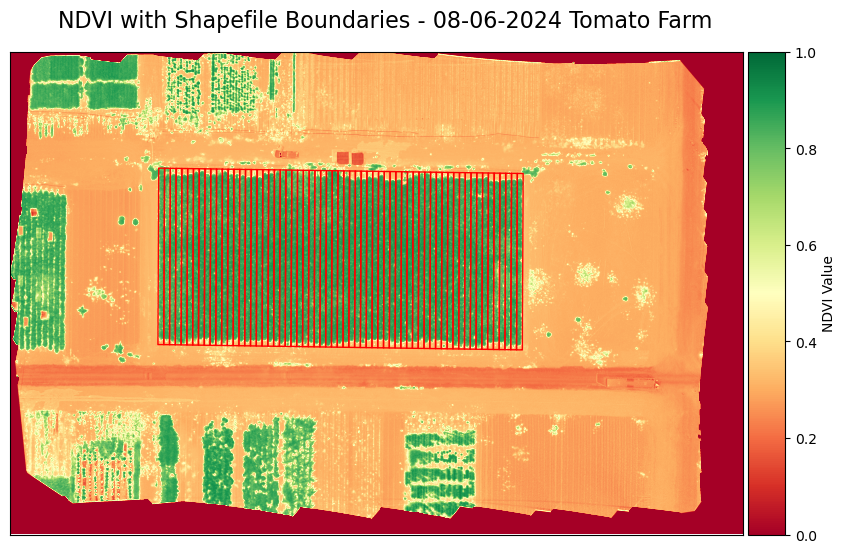

In [7]:
# File paths to the Red and NIR band rasters
red_band_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\Data\08-06-2024_DrKisekka-Tomato_Farm_transparent_reflectance_red.tif"
nir_band_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\Data\08-06-2024_DrKisekka-Tomato_Farm_transparent_reflectance_nir.tif"

# File path to the updated shapefile
shapefile_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\SHP\DrKisekka_Tomato\Procedures\Shapefile\polygons_shapefile_Updated\polygons_shapefile_Updated.shp"

# Open and read the Red band
with rasterio.open(red_band_path) as red_band:
    red_band_data = red_band.read(1)
    red_band_data = np.clip(red_band_data, 0, None)  # Replace negative values with 0
    ndvi_crs = red_band.crs  # Get the CRS of the NDVI data
    ndvi_bounds = red_band.bounds  # Get the extent (bounds) of the raster

# Open and read the NIR band
with rasterio.open(nir_band_path) as nir_band:
    nir_band_data = nir_band.read(1)
    nir_band_data = np.clip(nir_band_data, 0, None)  # Replace negative values with 0

# Calculate NDVI
ndvi = (nir_band_data - red_band_data) / (nir_band_data + red_band_data + 1e-10)  # Small epsilon added to avoid division by zero

# Set the range for NDVI values to -1 to 1
ndvi = np.clip(ndvi, -1, 1)

# Read the updated shapefile with geopandas
shapefile = gpd.read_file(shapefile_path)

# Reproject the shapefile to match the NDVI CRS if necessary
if shapefile.crs != ndvi_crs:
    shapefile = shapefile.to_crs(ndvi_crs)

# Create the plot using GeoPandas and Matplotlib
fig, ax = plt.subplots(figsize=(10, 8))

# Show the NDVI using the rasterio 'show' function which ensures proper spatial alignment
im = show(ndvi, transform=red_band.transform, cmap='RdYlGn', vmin=0, vmax=1, ax=ax)

# Overlay the shapefile boundaries with red edges
shapefile.boundary.plot(ax=ax, edgecolor='red', linewidth=1)

# Add a color bar for NDVI
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im.get_images()[0], cax=cax, label="NDVI Value")  # Use the color bar for NDVI values

# Add labels and center the title, using 'y' to adjust the title's vertical position
plt.suptitle("NDVI with Shapefile Boundaries - 08-06-2024 Tomato Farm", x=0.5, y=0.85, ha='center', fontsize=16)

# Turn off axis labels and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Show the plot
plt.show()

----------
## Calculate NDVI Statistics for Each Tomato Row

In this section, we overlay the NDVI map with the shapefile of the tomato farm rows (T_row 1 to 63). For each rectangle corresponding to a row in the farm (as represented by the `T_row` field in the shapefile), we calculate the following NDVI statistics:
- **Minimum NDVI**
- **Maximum NDVI**
- **Average NDVI**
- **Median NDVI**

The results are reported in a table where each row corresponds to a `T_row`, and the columns contain the respective NDVI statistics.

In [8]:
# File paths to the NDVI and shapefile
red_band_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\Data\08-06-2024_DrKisekka-Tomato_Farm_transparent_reflectance_red.tif"
nir_band_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\Data\08-06-2024_DrKisekka-Tomato_Farm_transparent_reflectance_nir.tif"
shapefile_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\SHP\DrKisekka_Tomato\Procedures\Shapefile\polygons_shapefile_Updated\polygons_shapefile_Updated.shp"

# Open and read the Red and NIR bands
with rasterio.open(red_band_path) as red_band:
    red_band_data = red_band.read(1)
    red_band_data = np.clip(red_band_data, 0, None)  # Replace negative values with 0
    ndvi_crs = red_band.crs  # Get the CRS of the NDVI data
    ndvi_transform = red_band.transform  # Get the transform of the NDVI

with rasterio.open(nir_band_path) as nir_band:
    nir_band_data = nir_band.read(1)
    nir_band_data = np.clip(nir_band_data, 0, None)  # Replace negative values with 0

# Calculate NDVI
ndvi = (nir_band_data - red_band_data) / (nir_band_data + red_band_data + 1e-10)
ndvi = np.clip(ndvi, -1, 1)  # Clip NDVI values to the range -1 to 1

# Read the shapefile with the T_rows
shapefile = gpd.read_file(shapefile_path)

# Reproject the shapefile to match the NDVI CRS if necessary
if shapefile.crs != ndvi_crs:
    shapefile = shapefile.to_crs(ndvi_crs)

# Create an empty list to hold the NDVI statistics
ndvi_stats = []

# Loop through each T_row in the shapefile
for _, row in shapefile.iterrows():
    # Get the geometry (polygon) for the current T_row
    geometry = row['geometry']
    
    # Create a mask of the NDVI data where the polygon is located
    mask = rasterio.features.geometry_mask([geometry], transform=ndvi_transform, invert=True, out_shape=ndvi.shape)
    
    # Apply the mask to the NDVI data to extract NDVI values for this polygon
    ndvi_values_in_polygon = ndvi[mask]
    
    # Calculate statistics for the current T_row
    min_ndvi = np.min(ndvi_values_in_polygon)
    max_ndvi = np.max(ndvi_values_in_polygon)
    avg_ndvi = np.mean(ndvi_values_in_polygon)
    median_ndvi = np.median(ndvi_values_in_polygon)
    
    # Append the statistics to the list
    ndvi_stats.append({
        'T_row': row['T_row'],
        'Min NDVI': min_ndvi,
        'Max NDVI': max_ndvi,
        'Avg NDVI': avg_ndvi,
        'Median NDVI': median_ndvi
    })

# Convert the list to a pandas DataFrame
ndvi_stats_df = pd.DataFrame(ndvi_stats)

# File path to save the CSV
csv_file_path = r"C:\Users\15302\Downloads\DrKisekka_Tomato\SHP\DrKisekka_Tomato\CSV\ndvi_statistics.csv"

# Save the DataFrame to a CSV file
ndvi_stats_df.to_csv(csv_file_path, index=False)

# Change pandas display options to show the entire DataFrame
pd.set_option('display.max_rows', None)  # Set the max rows to None to display all rows
pd.set_option('display.max_columns', None)  # Set the max columns to None to display all columns

# Display the DataFrame properly in Jupyter Notebook
from IPython.display import display
display(ndvi_stats_df)

,T_row,Min NDVI,Max NDVI,Avg NDVI,Median NDVI
0,1,0.292895,0.905243,0.776103,0.819461
1,2,0.299648,0.898416,0.769655,0.811888
2,3,0.302086,0.907944,0.795964,0.833704
3,4,0.284377,0.900679,0.777486,0.821106
4,5,0.260260,0.915845,0.810768,0.845294
5,6,0.286055,0.911459,0.805762,0.846388
6,7,0.290043,0.920338,0.832236,0.863085
7,8,0.242104,0.918445,0.833681,0.867689
8,9,0.291374,0.922246,0.814388,0.857017
9,10,0.287791,0.918158,0.824628,0.858600


-----------
## Contact Information

For more questions, feel free to contact **Mohammadreza Narimani** via email at [mnarimani@ucdavis.edu](mailto:mnarimani@ucdavis.edu).